In [4]:
!pip install py7zr

In [ ]:
import py7zr
import os

# Define paths
seven_zip_path = "/content/drive/MyDrive/Colab Notebooks/dataset.7z"
extract_to = "/content/skin_cancer_dataset"  # Destination

# Create extract folder if not exists
os.makedirs(extract_to, exist_ok=True)

# Extract
with py7zr.SevenZipFile(seven_zip_path, mode='r') as archive:
    archive.extractall(path=extract_to)

print("Extraction complete.")


Extraction complete.


In [ ]:
import os

for root, dirs, files in os.walk(extract_to):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files}")
    break  # Just show the top-level

Root: /content/skin_cancer_dataset
Directories: ['Train', 'Test']
Files: []


In [5]:
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# Define paths
extract_to = "/content/skin_cancer_dataset"  # Destination

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
train_data = datasets.ImageFolder(root=os.path.join(extract_to, 'Train'), transform=transform)
val_data = datasets.ImageFolder(root=os.path.join(extract_to, 'Test'), transform=transform) # Assuming 'Test' is the validation set

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Replace the classifier head
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 172MB/s]


In [7]:
import torch
import torch.nn as nn  # Add this import
import torch.optim as optim



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Accuracy: {train_acc:.2f}%")
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Accuracy: {train_acc:.2f}%")

Epoch 1, Loss: 171.178, Accuracy: 43.90%
Epoch 2, Loss: 98.874, Accuracy: 67.31%
Epoch 3, Loss: 66.412, Accuracy: 76.36%
Epoch 4, Loss: 50.230, Accuracy: 82.35%
Epoch 5, Loss: 36.427, Accuracy: 87.48%
Epoch 6, Loss: 30.020, Accuracy: 89.49%
Epoch 7, Loss: 24.366, Accuracy: 91.08%
Epoch 8, Loss: 23.270, Accuracy: 91.21%
Epoch 9, Loss: 20.322, Accuracy: 91.78%
Epoch 10, Loss: 19.043, Accuracy: 92.13%
Epoch 1, Loss: 18.784, Accuracy: 92.00%
Epoch 2, Loss: 18.260, Accuracy: 92.67%
Epoch 3, Loss: 15.567, Accuracy: 93.25%
Epoch 4, Loss: 16.216, Accuracy: 93.76%
Epoch 5, Loss: 15.810, Accuracy: 93.44%
Epoch 6, Loss: 15.238, Accuracy: 93.66%
Epoch 7, Loss: 14.844, Accuracy: 93.18%
Epoch 8, Loss: 14.550, Accuracy: 93.34%
Epoch 9, Loss: 14.834, Accuracy: 93.53%
Epoch 10, Loss: 13.295, Accuracy: 93.92%


In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

val_acc = 100. * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 56.78%


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


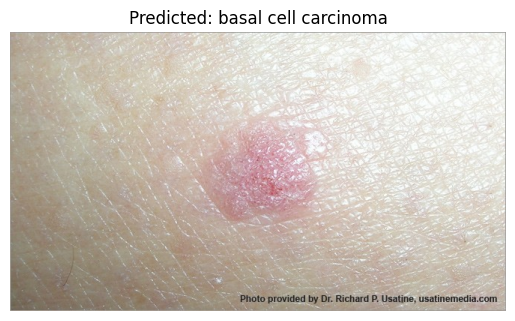

✅ Detected skin cancer type: basal cell carcinoma


In [9]:
# ✅ EfficientNet-Based Skin Cancer Classification + Inference

# ---- Step 6: Predict from Single Image ----
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import requests
from io import BytesIO
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

# Load EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Replace the classifier head
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Set image path (update this to your image location)s
image_path = "https://www.cancer.org/content/dam/cancer-org/images/galleries/skin-cancer-images/cancer-squamous-cell-carcinoma-02-restricted.jpg/jcr:content/renditions/cq5dam.web.1280.1280.jpeg"

# Download the image from the URL
response = requests.get(image_path)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load and preprocess the image
input_tensor = transform(img).unsqueeze(0).to(device)

# Model inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    predicted_label = class_names[predicted_class]

# Show result
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis("off")
plt.show()

print(f"✅ Detected skin cancer type: {predicted_label}")

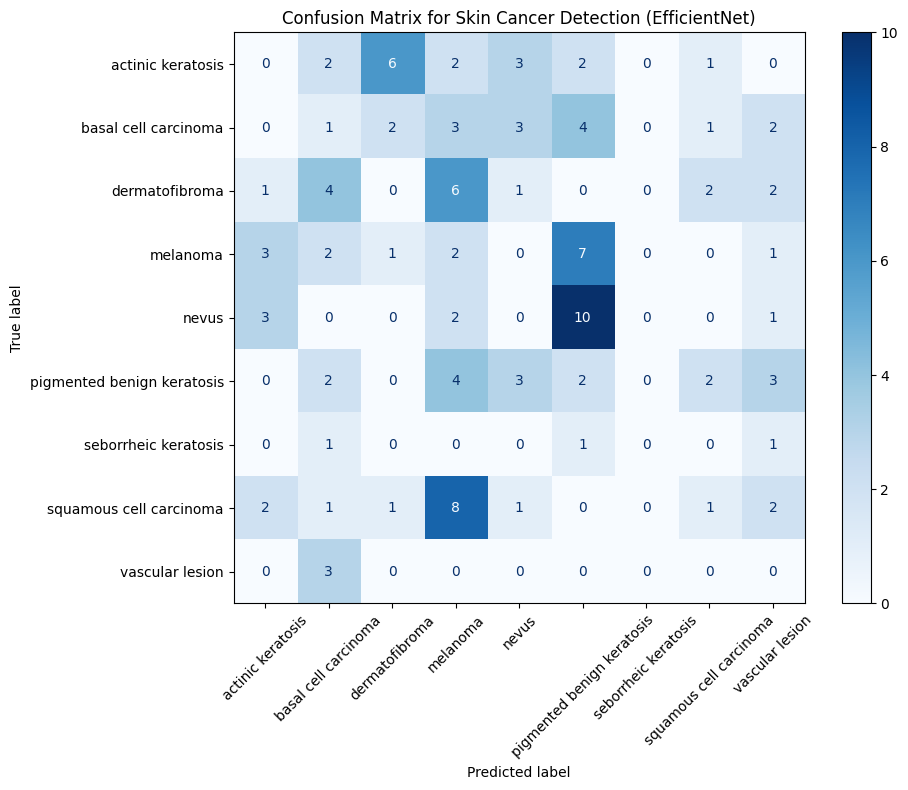

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Ensure model is in eval mode
model.eval()

# Store all true and predicted labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Skin Cancer Detection (EfficientNet)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-11-3658946265.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


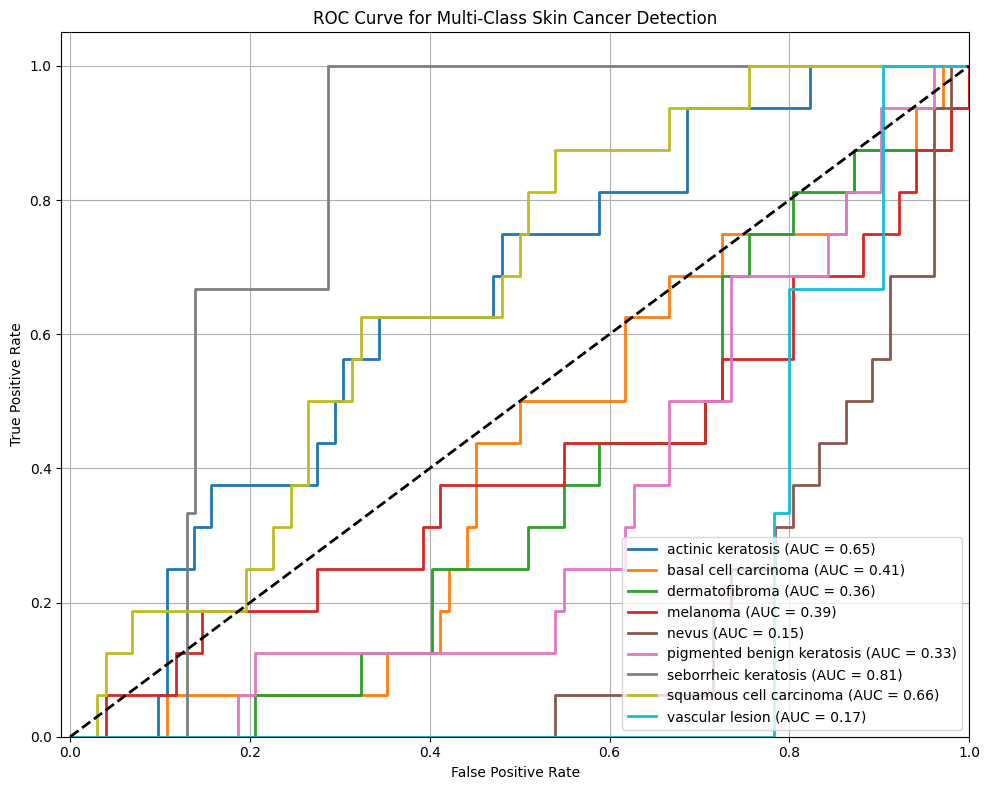

In [11]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

# Ensure model is in eval mode
model.eval()

# Get number of classes
n_classes = len(class_names)

# Store all labels and predicted probabilities
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.cpu().numpy()

        outputs = model(images)
        probs = F.softmax(outputs, dim=1).cpu().numpy()  # Get probabilities

        all_labels.extend(labels)
        all_probs.extend(probs)

# Convert to NumPy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Binarize the labels for multiclass ROC
y_true = label_binarize(all_labels, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Skin Cancer Detection')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import torch
import torch.nn.functional as F
import numpy as np

# Ensure model is in eval mode
model.eval()

# Number of classes
n_classes = len(class_names)

# Store true labels and predicted probabilities
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        all_probs.extend(probs)
        all_labels.extend(labels)

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Binarize the labels
y_true = label_binarize(all_labels, classes=np.arange(n_classes))

# Compute ROC AUC scores
auc_scores = {}
for i in range(n_classes):
    auc = roc_auc_score(y_true[:, i], all_probs[:, i])
    auc_scores[class_names[i]] = auc

# Print per-class AUC
print("Per-Class AUC Scores:")
for label, score in auc_scores.items():
    print(f"{label:30s}: AUC = {score:.4f}")

# Compute overall micro and macro AUC
micro_auc = roc_auc_score(y_true, all_probs, average='micro')
macro_auc = roc_auc_score(y_true, all_probs, average='macro')

print(f"\nMicro-Averaged AUC: {micro_auc:.4f}")
print(f"Macro-Averaged AUC: {macro_auc:.4f}")


Per-Class AUC Scores:
actinic keratosis             : AUC = 0.6458
basal cell carcinoma          : AUC = 0.4118
dermatofibroma                : AUC = 0.3578
melanoma                      : AUC = 0.3940
nevus                         : AUC = 0.1544
pigmented benign keratosis    : AUC = 0.3290
seborrheic keratosis          : AUC = 0.8145
squamous cell carcinoma       : AUC = 0.6612
vascular lesion               : AUC = 0.1710

Micro-Averaged AUC: 0.4633
Macro-Averaged AUC: 0.4377
